# Ghosts beam test
This notebook shows the different sets of ghosts obtained for different incident beams, in particular testing high angles

## TODO
- move `beam_test` to a module: `simulator`, `analysis` or `plotter`... or other

In [1]:
%load_ext autoreload
%autoreload 


In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid

from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom


from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3
from ghosts.geom_config import GEOM_CONFIG_0


In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


Direct path is number 28
  central impact point is (0.099486, 0.000013)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 677.8419


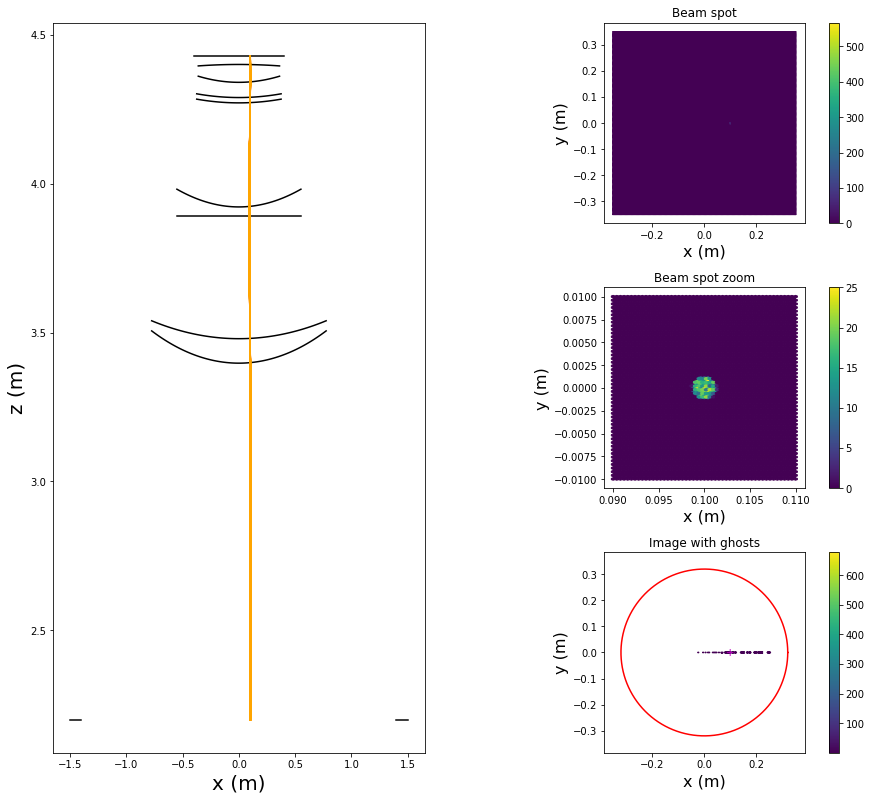

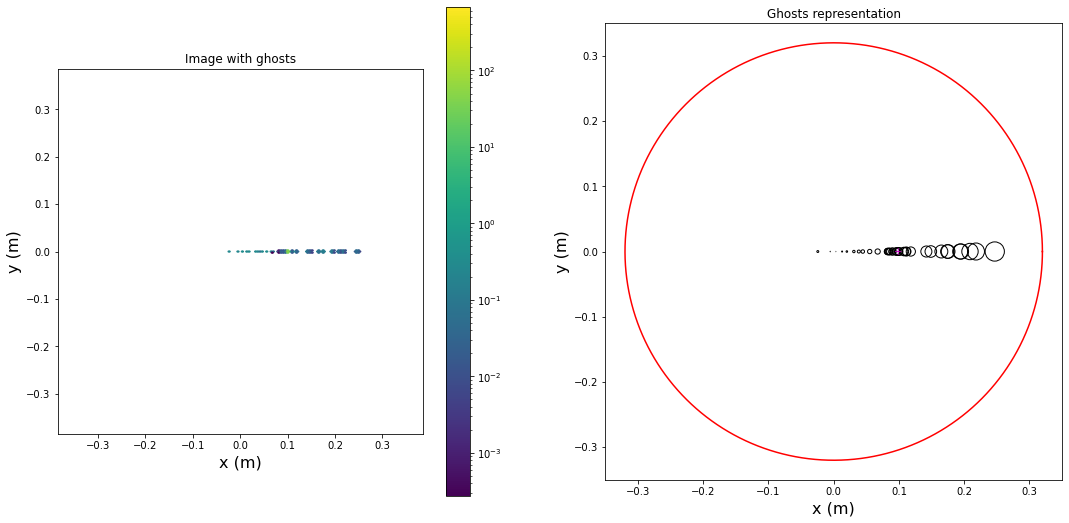

In [4]:
# Second CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
data_frame = make_data_frame(spots_data)
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)

In [5]:
def beam_test(telescope, beam_config):
    # Run simulation with standard beam config
    trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=beam_config)
    simulation = [trace_full, r_forward, r_reverse, rays]
    # Check setup
    plotter.plot_setup(telescope, simulation)

    # camera and ghosts visualization
    spots_data, _spots = reduce_ghosts(r_forward)
    data_frame = make_data_frame(spots_data)
    _fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)

Direct path is number 28
  central impact point is (0.015750, 0.067062)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 694.5562


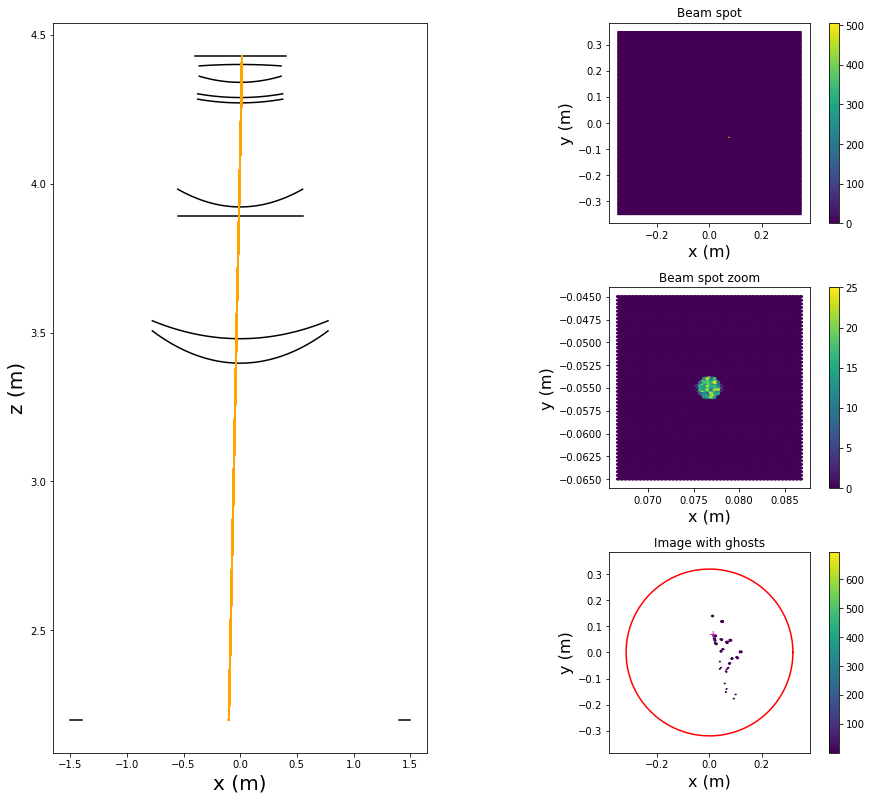

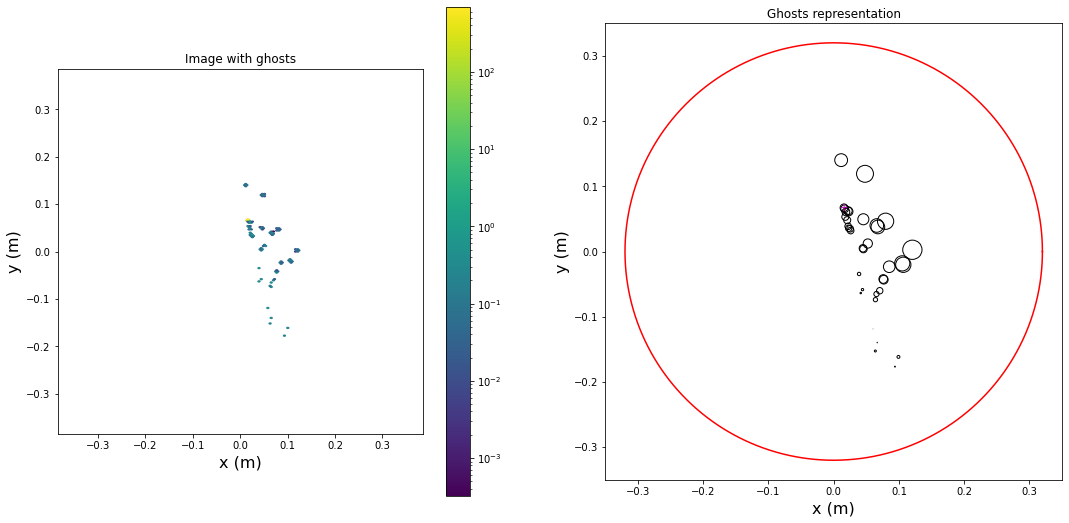

In [6]:
# Test beam - asymmetric, small angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.1
new_beam['y_offset'] = 0.3

new_beam['x_euler'] = 3
new_beam['y_euler'] = 6

beam_test(telescope, new_beam)

Direct path is number 25
  central impact point is (-0.123836, 0.056901)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 381.8565


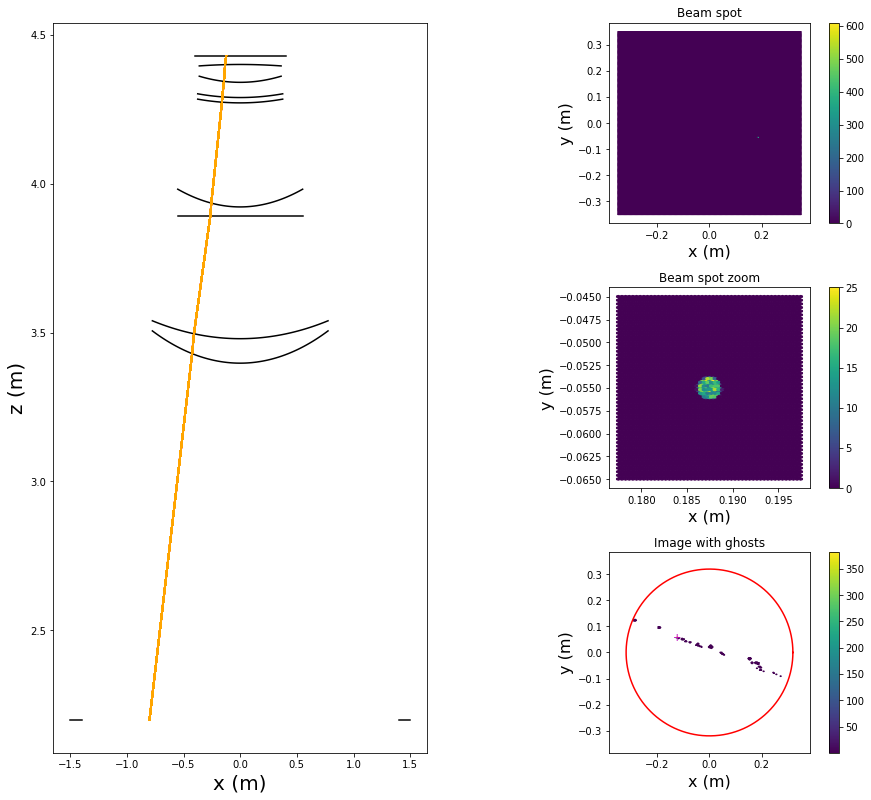

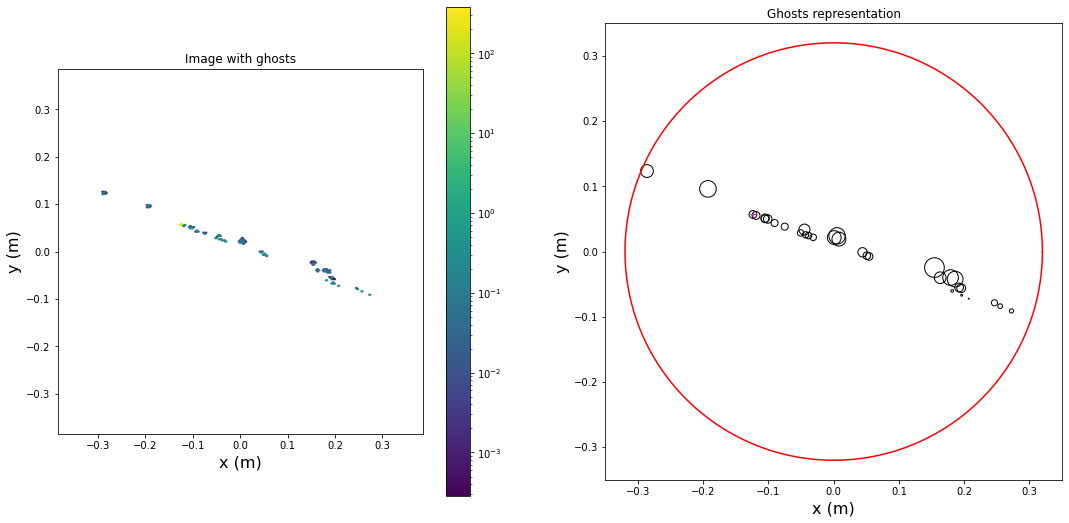

In [7]:
# Test beam - asymmetric, high angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.8
new_beam['y_offset'] = 0.3

new_beam['x_euler'] = 17
new_beam['y_euler'] = 6

beam_test(telescope, new_beam)

Direct path is number 22
  central impact point is (-0.123881, 0.092999)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 393.5289


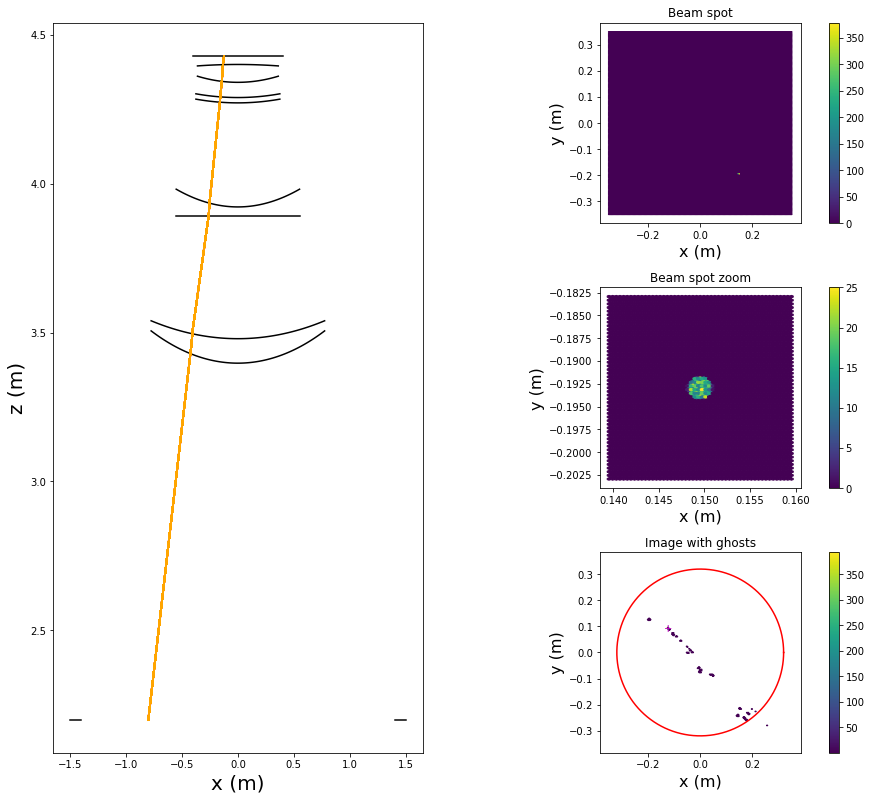

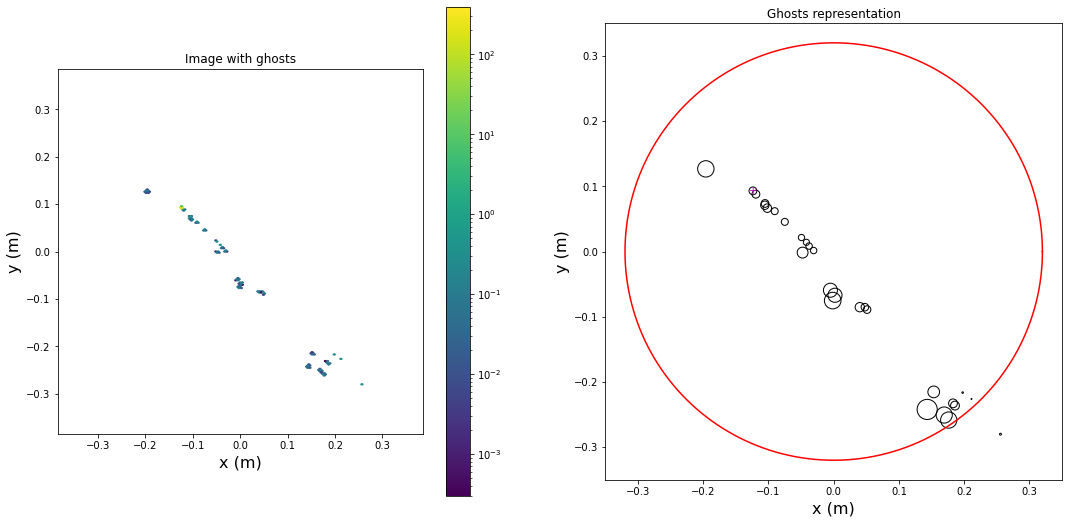

In [8]:
# Test beam - symmetric, high angles but all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.8
new_beam['y_offset'] = 0.8

new_beam['x_euler'] = 17
new_beam['y_euler'] = 17

beam_test(telescope, new_beam)

Direct path is number 9
  central impact point is (0.006276, -0.023499)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 601.9659


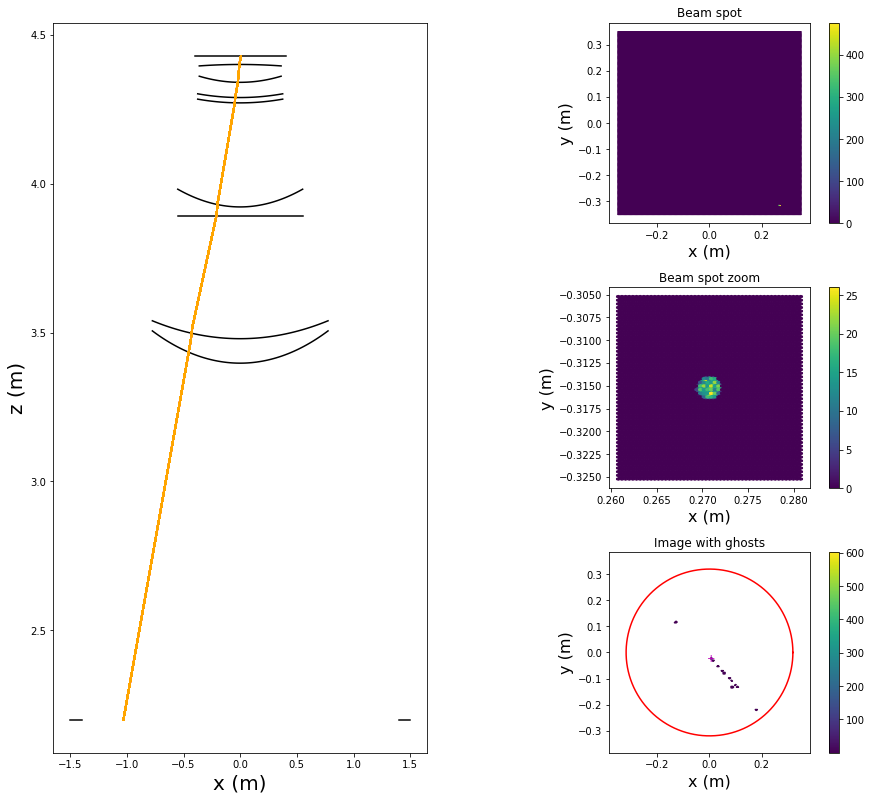

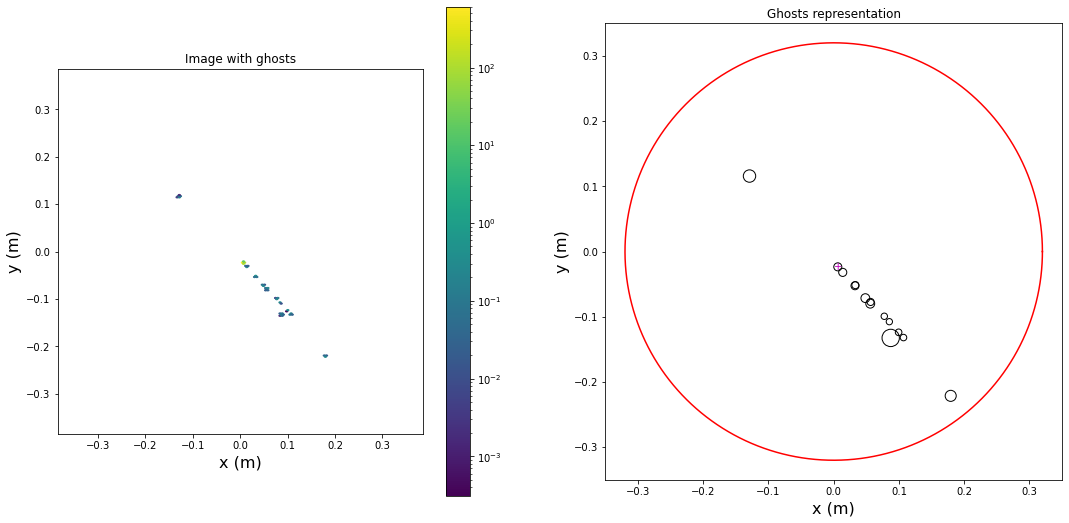

In [9]:
# Test beam - camera center !
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -1.03
new_beam['y_offset'] = 1.12

new_beam['x_euler'] = 25
new_beam['y_euler'] = 25

beam_test(telescope, new_beam)

Direct path is number 28
  central impact point is (0.075564, 0.049174)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 691.1852


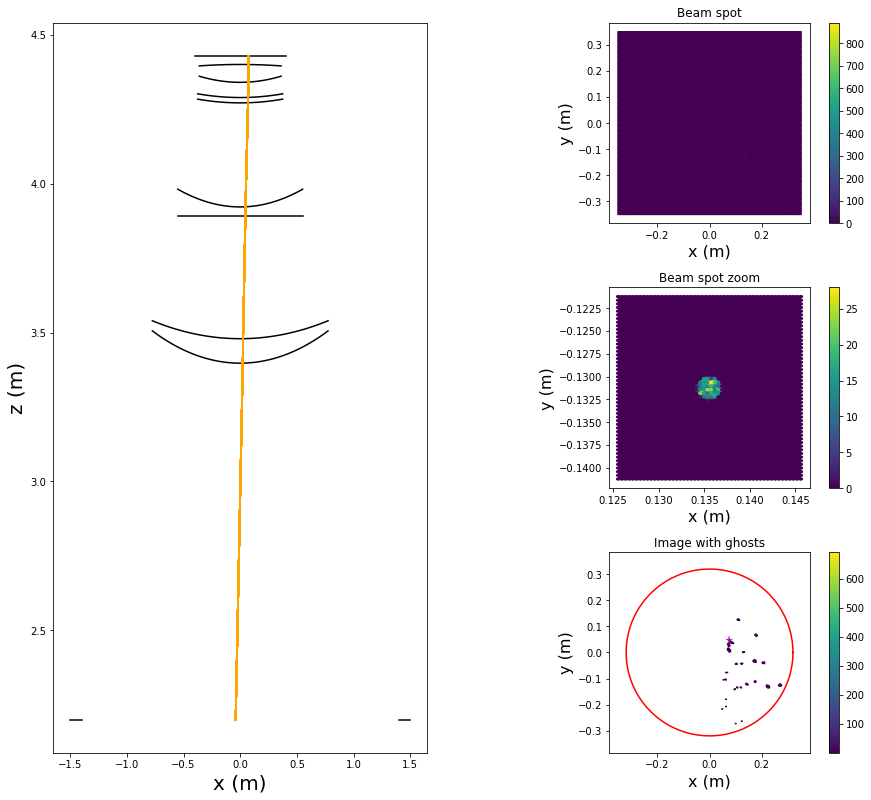

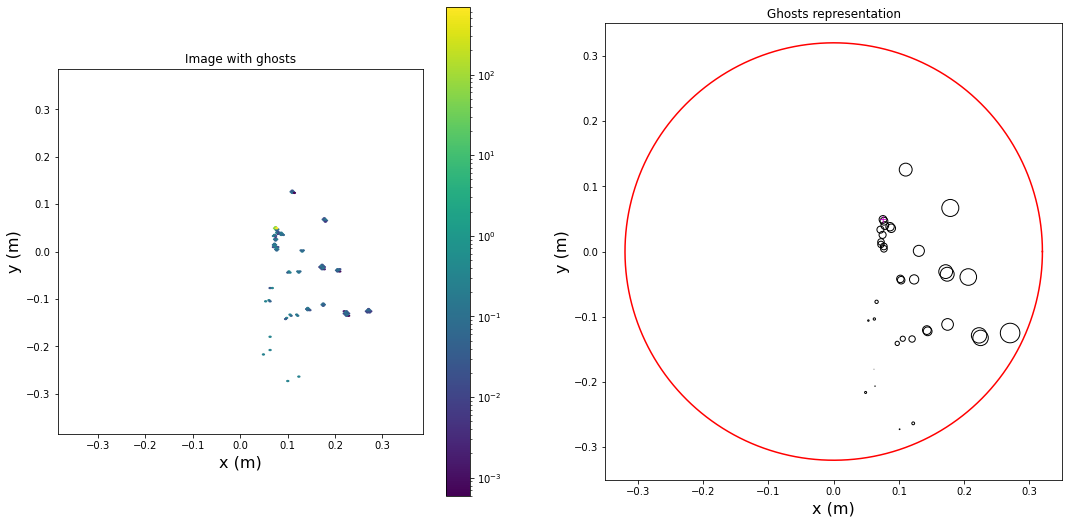

In [10]:
# Test beam- asymmetric, very large spread, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.04
new_beam['y_offset'] = 0.4

new_beam['x_euler'] = 3
new_beam['y_euler'] = 9

beam_test(telescope, new_beam)

Direct path is number 28
  central impact point is (-0.049649, -0.076976)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 833.8035


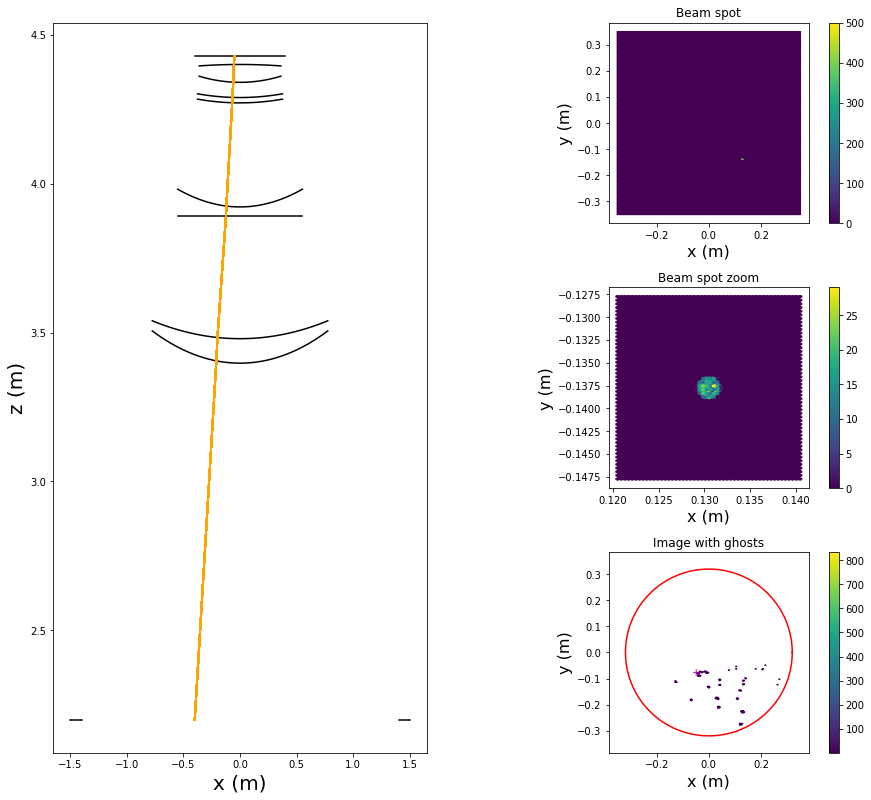

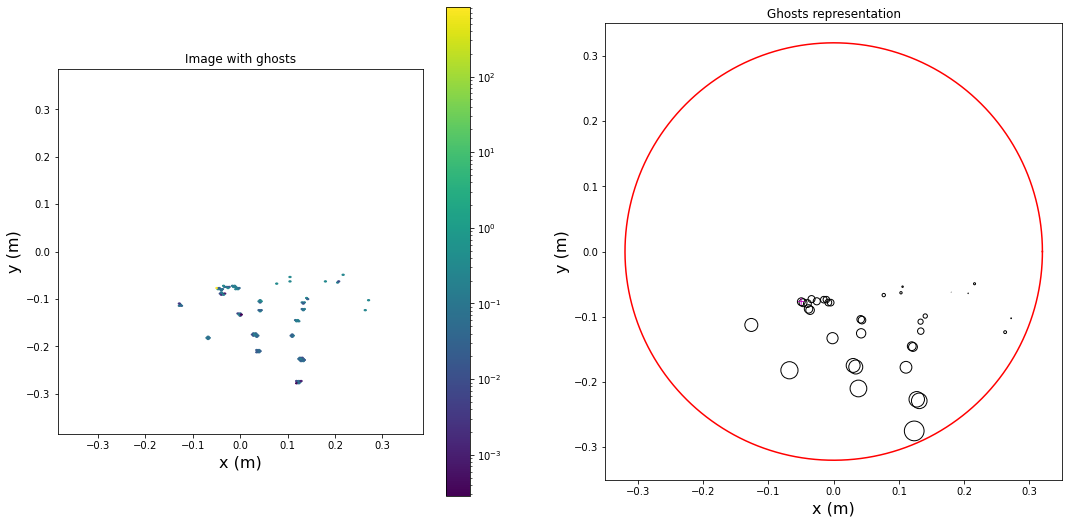

In [11]:
# Test beam- asymmetric, very large spread, iverted, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.4
new_beam['y_offset'] = 0.04

new_beam['x_euler'] = 9
new_beam['y_euler'] = 3

beam_test(telescope, new_beam)

Direct path is number 28
  central impact point is (-0.045718, -0.077003)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 722.1269


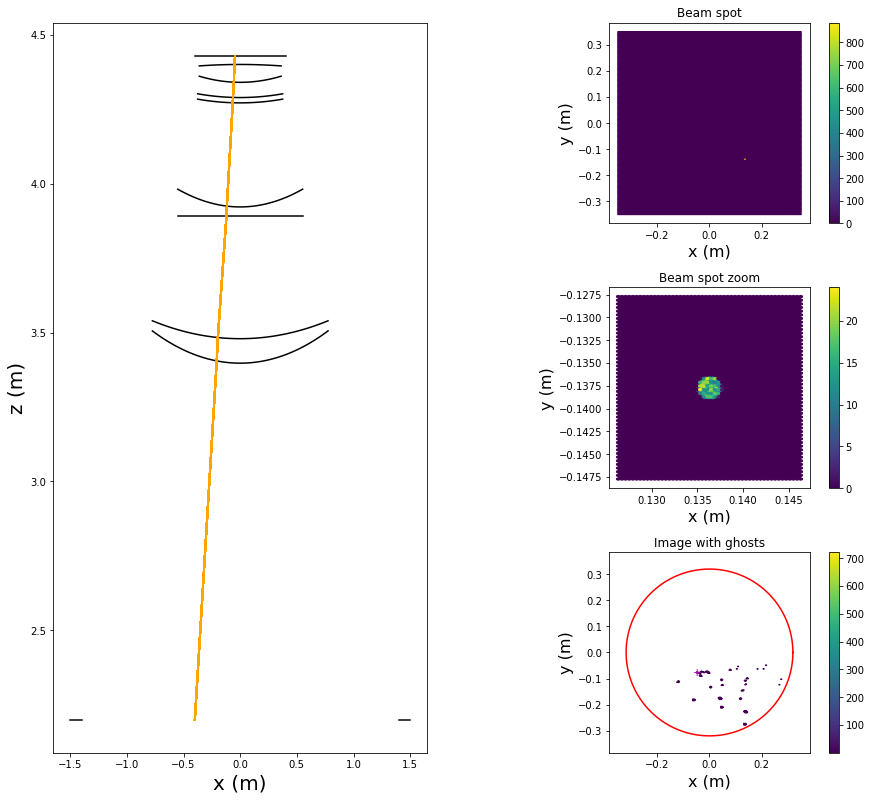

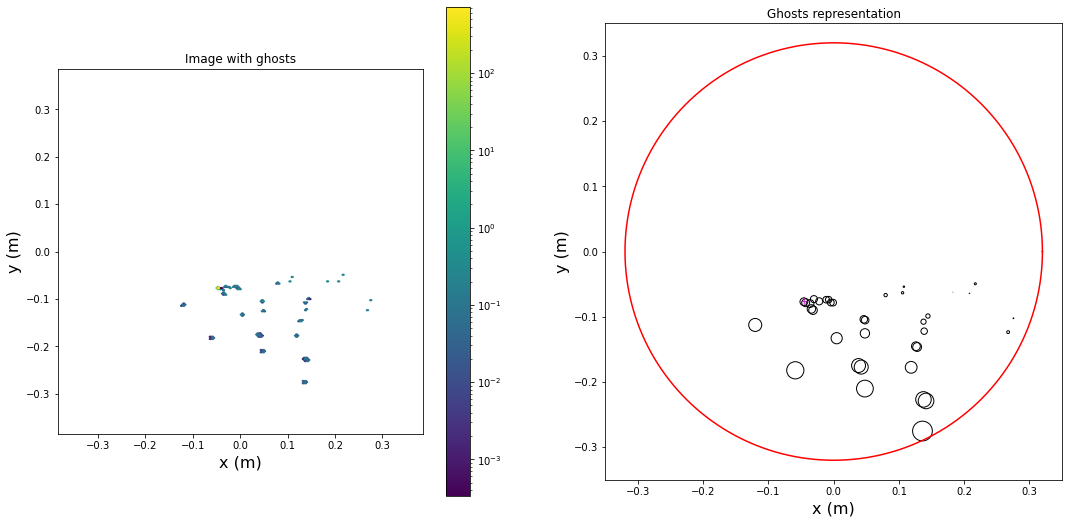

In [12]:
# Test beam - same, just move by 0.1 deg
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.4
new_beam['y_offset'] = 0.04

new_beam['x_euler'] = 9.1
new_beam['y_euler'] = 3

beam_test(telescope, new_beam)

tweak_optics::get_list_of_optics - Ignoring fake baffle
Direct path is number 28
  central impact point is (-0.053584, -0.078314)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 430.2138


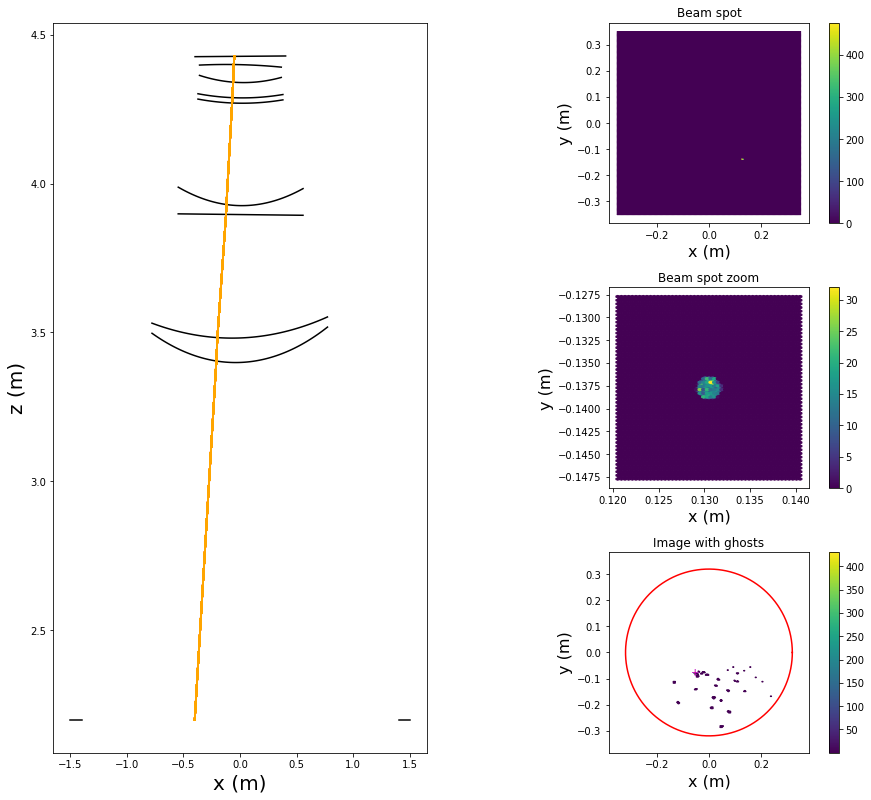

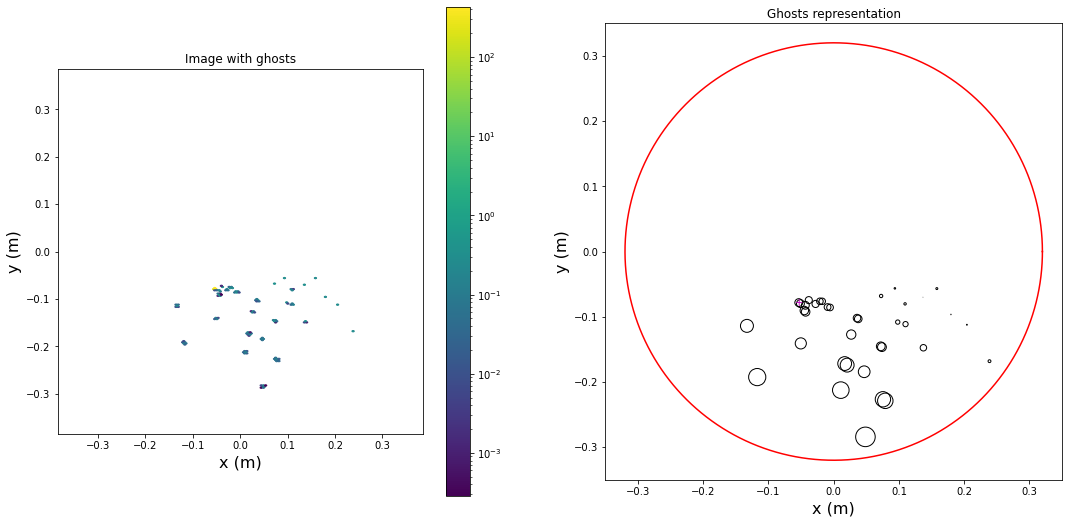

In [13]:
# Realistic setup with randomized telescope and beam at high angle
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")
rnd_telescope = tweak_optics.randomized_telescope(telescope, max_angle=1, max_shift=0.005)

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(rnd_telescope)

# new beam
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.4
new_beam['y_offset'] = 0.04

new_beam['x_euler'] = 9
new_beam['y_euler'] = 3

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(rnd_telescope, beam_config=new_beam)
simulation = [trace_full, r_forward, r_reverse, rays]

# Check setup
plotter.plot_setup(rnd_telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
data_frame = make_data_frame(spots_data)
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)